# Part 2: Feature Engineering

In [1]:
%pylab inline
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import random

%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import pickle 

Populating the interactive namespace from numpy and matplotlib


## Create training data

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
with open("crime_df.pkl", 'rb') as picklefile: 
    crime_df = pickle.load(picklefile)

In [4]:
crime_df['CMPLNT_FR_DT']= pd.to_datetime(crime_df['CMPLNT_FR_DT']) 
crime_df.sort_values(by=['CMPLNT_FR_DT'], ascending=True,  inplace=True)
crime_df.reset_index(drop = True, inplace = True)

In [5]:
# removing BX and SI
crime_df.drop(crime_df[crime_df.code.str.contains("BX")].index, inplace = True)
crime_df.drop(crime_df[crime_df.code.str.contains("SI")].index, inplace = True)

In [7]:
# converting time to day and night

import datetime 

def daynight(t):
    time = datetime.datetime.strptime(t,'%H:%M:%S').time()
    hr, mi = (time.hour, time.minute)
    if hr>=7 and hr<19: 
        return "day"
    else: 
        return "night"

In [8]:
crime_df['CMPLNT_FR_DAYNIGHT'] = crime_df['CMPLNT_FR_TM'].apply(daynight)

In [9]:
crime_df['CMPLNT_FR_MO'] = crime_df['CMPLNT_FR_DT'].apply(lambda x: x.month)

In [10]:
#remove code 99 (park) 98 (airport)
crime_df.drop(crime_df[crime_df.code.str.contains('99')].index, inplace = True)

In [11]:
crime_df.drop(crime_df[crime_df.code.str.contains('98')].index, inplace = True)

In [14]:
crime_df.to_csv('crime_df.csv')

In [13]:
df_X = (crime_df.groupby(['code','nta','CMPLNT_FR_MO', 'CMPLNT_FR_DT','CMPLNT_FR_DAYNIGHT',], as_index = False).CMPLNT_NUM.count()
        .rename(columns={'CMPLNT_FR_MO':'month','CMPLNT_FR_DAYNIGHT':'day/night','CMPLNT_FR_DT':'crime_date','CMPLNT_NUM':'crime_count'}))

In [14]:
df_X

,code,nta,month,crime_date,day/night,crime_count
0,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,day,1
1,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,night,2
2,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,day,1
3,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,night,2
4,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-04,day,1
...,...,...,...,...,...,...
228602,QN76,Baisley Park,12,2018-12-28,night,4
228603,QN76,Baisley Park,12,2018-12-29,day,2
228604,QN76,Baisley Park,12,2018-12-29,night,3
228605,QN76,Baisley Park,12,2018-12-30,day,1


## Feature Engineering: Census Data

- Total Population, Man/Female, Income Level, Poverty, Unemployment Rate at NTA code level

In [15]:
#nunique is always good to see before merging df

crime_df[['code','CensusTract', 'TotalPop', 'Men', 'Women', 'Income','Poverty','Unemployment']].nunique()

code            128
CensusTract     395
TotalPop        376
Men             378
Women           370
Income          381
Poverty         229
Unemployment    141
dtype: int64

In [16]:
fe_cen = crime_df.drop_duplicates(['code', 'CensusTract'])
fe_cen = fe_cen[['code', 'CensusTract', 'TotalPop', 'Men', 'Women', 'Income','Poverty','Unemployment']]

In [17]:
fe_cen

,code,CensusTract,TotalPop,Men,Women,Income,Poverty,Unemployment
0,QN15,36081101001,11028,5406,5622,24703.00,30.00,9.20
1,MN09,36061021100,10211,5074,5137,53389.00,29.50,5.50
2,MN11,36061022000,5379,2697,2682,47808.00,22.50,8.30
3,QN28,36081027900,6233,3224,3009,48170.00,14.50,7.40
6,QN20,36081055500,2348,1255,1093,46169.00,23.10,7.60
...,...,...,...,...,...,...,...,...
31110,QN30,36081053500,1328,626,702,50750.00,17.80,9.30
31959,QN49,36081094500,4127,2223,1904,72243.00,12.80,6.80
32701,QN45,36081148300,2920,1497,1423,109583.00,2.80,6.30
70231,QN72,36081010701,0,0,0,nan,nan,nan


In [18]:
fe_cen.fillna(0, inplace = True)

In [19]:
#make % to population
fe_cen['pov_pop'] = (fe_cen['TotalPop']*fe_cen['Poverty'])/100
fe_cen['unemp_pop'] = (fe_cen['TotalPop']*fe_cen['Unemployment'])/100

In [20]:
#groupby at code level
fe_cen_group = fe_cen.groupby(['code']).agg({'TotalPop': 'sum','Men': 'sum', 'Women': 'sum', 'Income': 'mean', 'pov_pop':'sum', 'unemp_pop': 'sum'})

In [21]:
fe_cen_group['code_pov'] = fe_cen_group['pov_pop'] / fe_cen_group["TotalPop"] * 100
fe_cen_group['code_unemp'] = fe_cen_group['unemp_pop'] / fe_cen_group["TotalPop"] *100

In [22]:
fe_cen_group

,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp
code,,,,,,,,
BK09,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
BK17,22604,10628,11976,61091.67,2928.96,1721.58,12.96,7.62
BK19,8356,4135,4221,67793.00,817.35,363.17,9.78,4.35
BK21,13140,5950,7190,43276.00,3919.44,2214.95,29.83,16.86
BK23,5373,2235,3138,53158.00,462.08,451.33,8.60,8.40
...,...,...,...,...,...,...,...,...
QN68,2806,1504,1302,27012.50,642.57,159.94,22.90,5.70
QN70,14876,7358,7518,50759.60,2789.04,1374.23,18.75,9.24
QN71,6320,3071,3249,49798.00,2153.57,1217.84,34.08,19.27


In [23]:
df_X = pd.merge(df_X, fe_cen_group, how = "left",  left_on = 'code', right_on = 'code' )
df_X

,code,nta,month,crime_date,day/night,crime_count,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp
0,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
1,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
2,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
3,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
4,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-04,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228602,QN76,Baisley Park,12,2018-12-28,night,4,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25
228603,QN76,Baisley Park,12,2018-12-29,day,2,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25
228604,QN76,Baisley Park,12,2018-12-29,night,3,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25
228605,QN76,Baisley Park,12,2018-12-30,day,1,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25


## Feature Engineering: Crime_level

- Define crime level: high and low

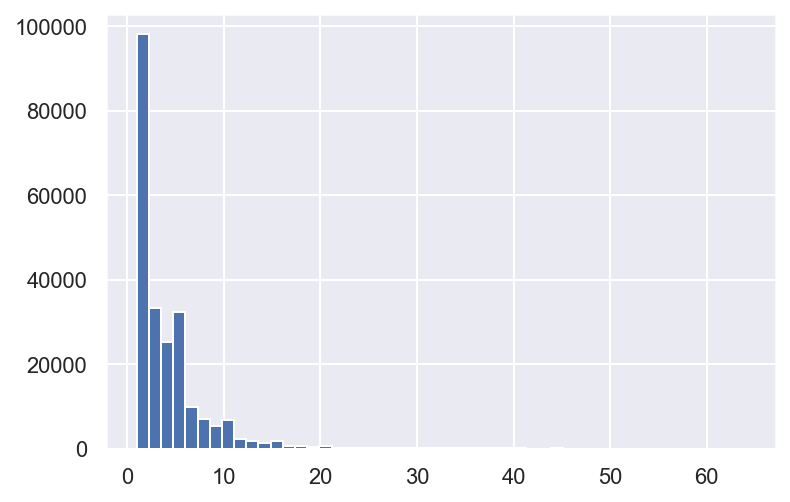

In [24]:
plt.hist(df_X.crime_count, bins = 50);

In [45]:
df_X.crime_count.value_counts()

1     54505
2     43533
3     33346
4     25230
5     18732
6     13495
7      9796
8      6962
9      5262
10     3768
11     2920
12     2212
13     1681
14     1305
15     1059
16      814
17      666
18      574
19      382
20      343
21      258
22      217
23      174
24      172
25      121
27      105
26       97
29       90
31       80
28       79
30       74
32       67
35       66
38       52
34       51
33       47
37       46
36       44
39       30
40       29
41       28
45       17
44       16
42       16
43       13
49        7
47        5
54        4
46        4
51        3
52        3
48        2
55        1
57        1
53        1
50        1
64        1
Name: crime_count, dtype: int64

In [26]:
df_X.crime_count.mean()

4.1424803264991885

In [27]:
len(df_X[df_X.crime_count > 4])/len(df_X)

0.31492036551811625

In [52]:
def crime_high_low(n):
    if n <= 4:
        return 'Low'
    else:
        return 'High'

In [53]:
df_X['crime_level'] = df_X['crime_count'].apply(crime_high_low)

In [54]:
df_X.crime_level.value_counts()

Low       98038
Medium    77308
High      53261
Name: crime_level, dtype: int64

In [32]:
import geopandas

nta_poly = geopandas.read_file('Data/nynta_19d (shp)/nynta.shp')

In [33]:
nta_poly.head(2)

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK88,Borough Park,39247.23,54005019.05,"POLYGON ((990897.900 169268.121, 990588.252 16..."
1,4,Queens,081,QN51,Murray Hill,33266.90,52488277.85,"POLYGON ((1038593.459 221913.355, 1039369.281 ..."


In [34]:
df_X = pd.merge(df_X, nta_poly[['NTACode','geometry']], how = "left",  left_on = 'code', right_on = 'NTACode' )
del df_X['NTACode']

In [36]:
df_X

,code,nta,month,crime_date,day/night,crime_count,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp,crime_level,geometry
0,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19..."
1,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-01,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19..."
2,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19..."
3,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-03,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19..."
4,BK09,Brooklyn Heights-Cobble Hill,1,2016-01-04,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228602,QN76,Baisley Park,12,2018-12-28,night,4,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ..."
228603,QN76,Baisley Park,12,2018-12-29,day,2,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ..."
228604,QN76,Baisley Park,12,2018-12-29,night,3,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ..."
228605,QN76,Baisley Park,12,2018-12-30,day,1,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ..."


In [35]:
with open('df_X.pkl', 'wb') as picklefile:
    pickle.dump(df_X, picklefile)

## Feature Engineering: Weather data

- Add precipitation, snow level, temprature to the dataset

In [360]:
wea = pd.read_csv('data/weather_data.csv')

In [361]:
wea.drop(columns = ['ELEVATION','SNWD','TAVG', 'TMAX', 'TMIN', 'WESD'], inplace = True)

In [363]:
wea.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE', 'PRCP', 'SNOW',
       'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11'],
      dtype='object')

In [364]:
wea.fillna(0, inplace = True)

In [365]:
def decimals(n):
    try: 
        return "{:.2f}".format(n)
    except:
        return np.nan

In [366]:
wea['LATITUDE'] = wea['LATITUDE'].apply(decimals)
wea['LONGITUDE'] = wea['LONGITUDE'].apply(decimals)
wea['lat_lon'] = wea['LATITUDE'] + wea['LONGITUDE']
wea['DATE'] = pd.to_datetime(wea['DATE'])

In [367]:
wea_df = wea[['DATE','lat_lon','LATITUDE','LONGITUDE','PRCP','SNOW', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11']]
wea_df[wea_df['lat_lon'] == '40.30-74.00']

,DATE,lat_lon,LATITUDE,LONGITUDE,PRCP,SNOW,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
1783,2016-01-01,40.30-74.00,40.30,-74.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1784,2016-01-02,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1785,2016-01-03,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1786,2016-01-04,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1787,2016-01-05,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43294,2019-03-27,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43295,2019-03-28,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43296,2019-03-29,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
43297,2019-03-30,40.30-74.00,40.30,-74.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [368]:
ref = wea_df.drop_duplicates(['DATE'])
ref

,DATE,lat_lon,LATITUDE,LONGITUDE,PRCP,SNOW,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
0,2016-01-01,41.06-73.77,41.06,-73.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2016-01-02,41.06-73.77,41.06,-73.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2016-01-03,41.06-73.77,41.06,-73.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2016-01-04,41.06-73.77,41.06,-73.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2016-01-05,41.06-73.77,41.06,-73.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,2019-03-29,40.89-74.40,40.89,-74.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1620,2019-03-30,40.89-74.40,40.89,-74.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1621,2019-03-31,40.89-74.40,40.89,-74.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1805,2016-01-23,40.30-74.00,40.30,-74.00,1.19,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [375]:
ref.columns

Index(['DATE', 'lat_lon', 'LATITUDE', 'LONGITUDE', 'PRCP', 'SNOW', 'WT01',
       'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11'],
      dtype='object')

In [379]:
df_X_w = pd.merge(df_X, ref[['DATE','PRCP', 'SNOW', 'WT01',
       'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'WT11']], how = 'left', left_on = 'crime_date', right_on = 'DATE' )

In [381]:
del df_X_w['DATE']

In [382]:
with open('df_X_w.pkl', 'wb') as picklefile:
    pickle.dump(df_X_w, picklefile)